# 1. Import Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
path = r'/Users/bazillaimran/Documents/02-2023 Instacart Basket Analysis'

In [3]:
ords_prods_customers = pd.read_pickle(os.path.join(path,'02 Data','Prepared Data','ords_prods_customers_merged.pkl'))

In [4]:
ords_prods_customers.head()

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,...,First Name,Last Name,Gender,State,Age,date_joined,dependants,family_status,income,_merge
0,1,Chocolate Sandwich Cookies,61,19,5.8,3139998,138,28,6,11,...,Charles,Cox,Male,Minnesota,81,2019-08-01,1,married,49620,both
1,1,Chocolate Sandwich Cookies,61,19,5.8,1977647,138,30,6,17,...,Charles,Cox,Male,Minnesota,81,2019-08-01,1,married,49620,both
2,907,Premium Sliced Bacon,106,12,20.0,3160996,138,1,5,13,...,Charles,Cox,Male,Minnesota,81,2019-08-01,1,married,49620,both
3,907,Premium Sliced Bacon,106,12,20.0,2254091,138,10,5,14,...,Charles,Cox,Male,Minnesota,81,2019-08-01,1,married,49620,both
4,1000,Apricots,18,10,12.9,505689,138,9,6,12,...,Charles,Cox,Male,Minnesota,81,2019-08-01,1,married,49620,both


In [5]:
ords_prods_customers = ords_prods_customers.drop(columns = ['_merge'])

In [6]:
ords_prods_customers.shape

(32404859, 32)

# 2. Consider any security implications - address any PII data

Security Implication : The data set includes PII's namely : first and last name, family status, income and marital status.

# Create a regional segmentation of the data - create a regional column based on the state column

In [7]:
#Creating a region column based on wikipedia information
# Create a new column 'region' and use loc for mapping
ords_prods_customers['region'] = 'West'

ords_prods_customers.loc[
    ords_prods_customers['State'].isin(['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']),
    'region'
] = 'Northeast'

ords_prods_customers.loc[
    ords_prods_customers['State'].isin(['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']),
    'region'
] = 'Midwest'

ords_prods_customers.loc[
    ords_prods_customers['State'].isin(['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']),
    'region'
] = 'South'

In [8]:
ords_prods_customers.tail()

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,...,First Name,Last Name,Gender,State,Age,date_joined,dependants,family_status,income,region
32404854,49235,Organic Half & Half,53,16,1.8,2542346,80734,3,3,8,...,Frank,Bowers,Male,Alabama,45,2019-09-28,1,married,41072,South
32404855,49520,Orange Sparkling Water,115,7,7.5,1363278,74506,1,1,14,...,Joe,Coffey,Male,Vermont,44,2018-04-16,3,married,97209,Northeast
32404856,49520,Orange Sparkling Water,115,7,7.5,2008002,74506,2,0,15,...,Joe,Coffey,Male,Vermont,44,2018-04-16,3,married,97209,Northeast
32404857,49520,Orange Sparkling Water,115,7,7.5,1595973,74506,3,1,17,...,Joe,Coffey,Male,Vermont,44,2018-04-16,3,married,97209,Northeast
32404858,49520,Orange Sparkling Water,115,7,7.5,1680478,74506,4,0,16,...,Joe,Coffey,Male,Vermont,44,2018-04-16,3,married,97209,Northeast


In [9]:
#frequency check
ords_prods_customers['region'].value_counts()

region
South        10791885
West          8292913
Midwest       7597325
Northeast     5722736
Name: count, dtype: int64

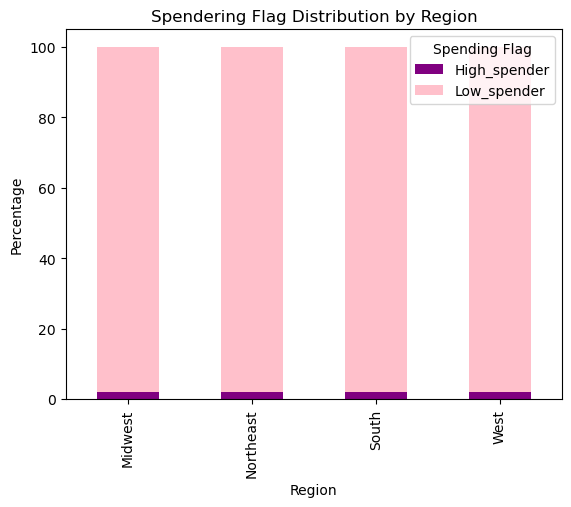

In [10]:
#making groups and normalizing the result
spending_by_region = ords_prods_customers.groupby('region')['spender_flag'].value_counts(normalize=True).unstack() * 100
#defining colors
colors = ['purple', 'pink']

# Plotting the bar chart
ax = spending_by_region.plot(kind='bar', stacked=True, color=colors)

# Adding labels and title
ax.set_xlabel('Region')
ax.set_ylabel('Percentage')
ax.set_title('Spendering Flag Distribution by Region')

# Display the legend
ax.legend(title='Spending Flag', loc='upper right')

Spending flag seems to be same at each region.

In [11]:
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'spenders_region_bar.png'), bbox_inches='tight', pad_inches=0.1)

<Figure size 640x480 with 0 Axes>

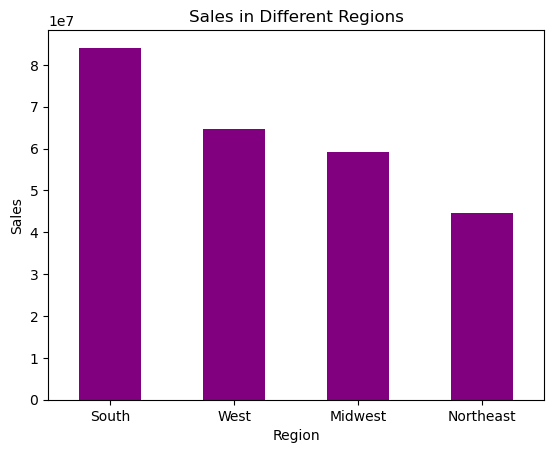

In [12]:
#purchased product prices in different regions
bar_price_region = ords_prods_customers.groupby('region')['prices'].sum().sort_values(ascending=False).plot.bar(
    title='Sales in Different Regions', xlabel='Region', ylabel='Sales', color='purple'
)
plt.xticks(rotation=0)
plt.show()

In [13]:
#Saving the bar chart
bar_price_region.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_prices_region.png'))

# 4. Creating an exclusion flag for low-activity customers (< 5 orders) and exclude them from the data

In [14]:
# making an "exclude_flag"
ords_prods_customers['exclude_flag'] = ords_prods_customers['max_order'] < 5

# Exclude low-activity customers from the data
df_ex = ords_prods_customers[~ords_prods_customers['exclude_flag']]

In [15]:
sample_less_5 = ords_prods_customers[ords_prods_customers['exclude_flag']]

In [16]:
df_ex.head()

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,...,Last Name,Gender,State,Age,date_joined,dependants,family_status,income,region,exclude_flag
0,1,Chocolate Sandwich Cookies,61,19,5.8,3139998,138,28,6,11,...,Cox,Male,Minnesota,81,2019-08-01,1,married,49620,Midwest,False
1,1,Chocolate Sandwich Cookies,61,19,5.8,1977647,138,30,6,17,...,Cox,Male,Minnesota,81,2019-08-01,1,married,49620,Midwest,False
2,907,Premium Sliced Bacon,106,12,20.0,3160996,138,1,5,13,...,Cox,Male,Minnesota,81,2019-08-01,1,married,49620,Midwest,False
3,907,Premium Sliced Bacon,106,12,20.0,2254091,138,10,5,14,...,Cox,Male,Minnesota,81,2019-08-01,1,married,49620,Midwest,False
4,1000,Apricots,18,10,12.9,505689,138,9,6,12,...,Cox,Male,Minnesota,81,2019-08-01,1,married,49620,Midwest,False


In [17]:
sample_less_5.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'less_than_5_order_customers.pkl'))

In [18]:
sample_less_5.shape

(1440295, 34)

In [19]:
#making a sub dataframe for next question.
selected_columns = ['product_id', 'product_name', 'department_id', 'prices',
                    'user_id', 'order_number', 'orders_day_of_week',
                    'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order', 'price_range_loc', 
                    'busiest_days', 'busiest_period_of_day', 'max_order', 'loyalty_flag', 'spender_flag',
                    'Customer_frequency', 'frequency_flag', 'Gender', 'State', 'Age', 'dependants', 'family_status',
                    'income','region']

In [20]:
df_ex_sub=df_ex[selected_columns]

In [21]:
df_ex_sub.shape

(30964564, 25)

In [22]:
df_ex_sub.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'under_5_excluded_sub.pkl'))

In [23]:
#Creating a true or false list to the test np.random.rant <=0.7
np.random.seed(4)
dev = np.random.rand(len(df_ex_sub)) <= 0.7

In [24]:
#Store 70% of the sample in dataframe big
big = df_ex_sub[dev]

In [25]:
#Store 30% of the sample in dataframe small
small = df_ex_sub[~dev]

In [26]:
# Export data to pkl

small.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'df_ex_sub_small_sample.pkl'))


ATTENTION: From now on I would provide all analysis and visualizations based on 70/30 sample file made on last notebook to prevent any probable memory error. small_sample.pickle has the 30% randomized sample data for my entire dataset. 

In [27]:
small.head()

,product_id,product_name,department_id,prices,user_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,add_to_cart_order,...,spender_flag,Customer_frequency,frequency_flag,Gender,State,Age,dependants,family_status,income,region
0,1,Chocolate Sandwich Cookies,19,5.8,138,28,6,11,3.0,5,...,Low_spender,8.0,Frequent Customer,Male,Minnesota,81,1,married,49620,Midwest
2,907,Premium Sliced Bacon,12,20.0,138,1,5,13,NaN,4,...,Low_spender,8.0,Frequent Customer,Male,Minnesota,81,1,married,49620,Midwest
3,907,Premium Sliced Bacon,12,20.0,138,10,5,14,6.0,1,...,Low_spender,8.0,Frequent Customer,Male,Minnesota,81,1,married,49620,Midwest
6,4913,Table Water Crackers,19,4.4,138,23,5,13,24.0,3,...,Low_spender,8.0,Frequent Customer,Male,Minnesota,81,1,married,49620,Midwest
10,7987,Hazelnut Spread with Cocoa,13,12.8,138,5,0,9,14.0,3,...,Low_spender,8.0,Frequent Customer,Male,Minnesota,81,1,married,49620,Midwest


In [28]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [29]:
small['income'].describe()

count   9288468.00
mean      99679.34
std       43136.87
min       25903.00
25%       67321.00
50%       96775.00
75%      128105.00
max      593901.00
Name: income, dtype: float64

In [30]:
# Set the income thresholds for low and high income
low_income_threshold = 50000
high_income_threshold = 100000

In [31]:
# Create a new column 'income_category' based on the 'income' column
small['income_category'] = pd.cut(
    small['income'],
    bins=[-float('inf'), low_income_threshold, high_income_threshold, float('inf')],
    labels=['Low Income', 'Middle Income', 'High Income'],
    include_lowest=True)

/var/folders/17/9z1yp8ss3r174mlj49ql3qgr0000gn/T/ipykernel_99593/2620801016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['income_category'] = pd.cut(


In [32]:
small.head()

,product_id,product_name,department_id,prices,user_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,add_to_cart_order,...,Customer_frequency,frequency_flag,Gender,State,Age,dependants,family_status,income,region,income_category
0,1,Chocolate Sandwich Cookies,19,5.80,138,28,6,11,3.00,5,...,8.00,Frequent Customer,Male,Minnesota,81,1,married,49620,Midwest,Low Income
2,907,Premium Sliced Bacon,12,20.00,138,1,5,13,NaN,4,...,8.00,Frequent Customer,Male,Minnesota,81,1,married,49620,Midwest,Low Income
3,907,Premium Sliced Bacon,12,20.00,138,10,5,14,6.00,1,...,8.00,Frequent Customer,Male,Minnesota,81,1,married,49620,Midwest,Low Income
6,4913,Table Water Crackers,19,4.40,138,23,5,13,24.00,3,...,8.00,Frequent Customer,Male,Minnesota,81,1,married,49620,Midwest,Low Income
10,7987,Hazelnut Spread with Cocoa,13,12.80,138,5,0,9,14.00,3,...,8.00,Frequent Customer,Male,Minnesota,81,1,married,49620,Midwest,Low Income


Text(0.5, 1.0, 'Income Category Distribution')

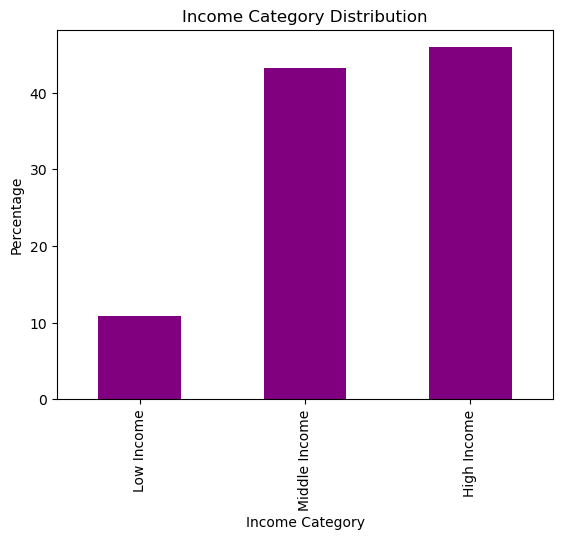

In [33]:
# Plot the percentage distribution of income categories
percentage_distribution = (small['income_category'].value_counts(normalize=True) * 100).sort_index()
percentage_distribution.plot.bar(color=['purple'])
plt.xlabel('Income Category')
plt.ylabel('Percentage')
plt.title('Income Category Distribution')

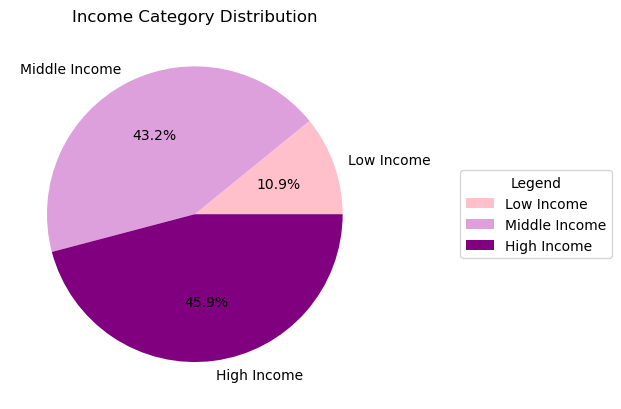

In [34]:
# Plot the pie chart
income_pie = plt.pie(percentage_distribution, labels=percentage_distribution.index, autopct='%1.1f%%', colors=['pink', 'plum', 'purple'])
plt.title('Income Category Distribution')
plt.legend(percentage_distribution.index, title="Legend", loc="center left", bbox_to_anchor=(1.2, 0.5))
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'pie_income.png'), bbox_inches='tight')

In [35]:
# Display the plot
plt.show()

In [36]:
small['Age'].describe()

count   9288468.00
mean         49.47
std          18.49
min          18.00
25%          33.00
50%          49.00
75%          65.00
max          81.00
Name: Age, dtype: float64

In [37]:
#making age-group column
def age_label(row):
    if row['Age'] <= 24:
        return 'young-adult'
    elif 24 < row['Age'] <= 44:
        return 'adult'
    elif 44 < row['Age'] < 60:
        return 'middle-age'
    else:
        return 'senior'

In [38]:
small['age_group'] = small.apply(age_label, axis=1)

/var/folders/17/9z1yp8ss3r174mlj49ql3qgr0000gn/T/ipykernel_99593/3545808766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['age_group'] = small.apply(age_label, axis=1)


In [39]:
small['age_group'].value_counts()

age_group
senior         3172688
adult          2897625
middle-age     2193328
young-adult    1024827
Name: count, dtype: int64

In [40]:
# Calculate the percentage distribution of age groups
percentage_distribution_age = (small['age_group'].value_counts(normalize=True) * 100).sort_index()

In [41]:
# Define four different shades of purple
colors = ['#6A5ACD', 'plum', 'purple', 'pink']

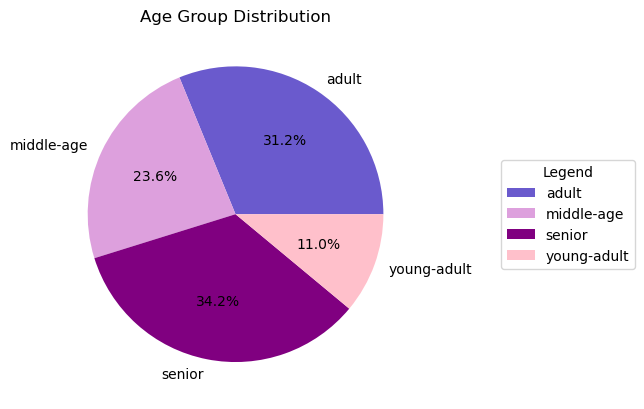

In [42]:
# Plot the pie chart with specified colors
pie_age_groups = plt.pie(percentage_distribution_age, labels=percentage_distribution_age.index, autopct='%1.1f%%', 
                         colors=colors)
plt.title('Age Group Distribution')
plt.legend(percentage_distribution_age.index, title="Legend", loc="center left", bbox_to_anchor=(1.2, 0.5))
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'pie_age_group.png'), bbox_inches='tight')

(array([0, 1, 2]),
 [Text(0, 0, 'Regular customer'),
  Text(1, 0, 'Loyal customer'),
  Text(2, 0, 'New customer')])

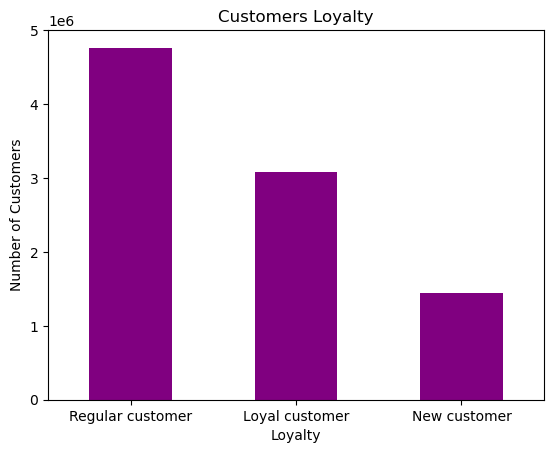

In [43]:
# Create a bar chart for showing the loyaltiy and number of orders
bar_orders_loyalty = small['loyalty_flag'].value_counts().plot.bar(title = 'Customers Loyalty', xlabel = 'Loyalty', ylabel = 'Number of Customers', color = 'purple')
plt.xticks(rotation=0)

In [44]:
# Saving
bar_orders_loyalty.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_orders_loyalty.png'))

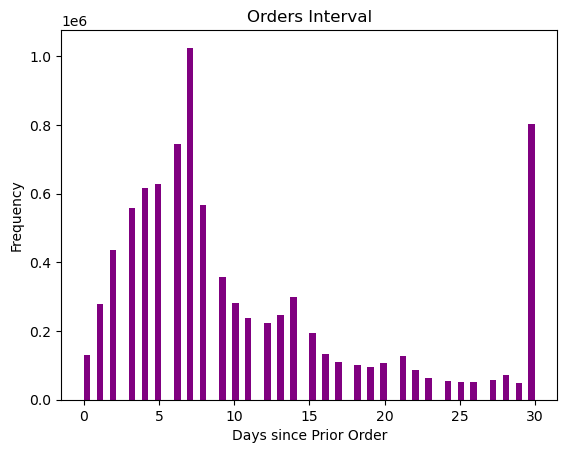

In [45]:
#order Interval  histogram
hist_order_interval = small['days_since_prior_order'].plot.hist(bins = 70, title = 'Orders Interval', xlabel = 'Days since Prior Order', color = 'purple')

In [46]:
# Saving
hist_order_interval.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'hist_order_interval.png'))

In [47]:
# Create a depend_flag to indicate whether the customers have dependants or not
small['avg_dependant'] = small.groupby(['user_id'])['dependants'].transform('mean')

/var/folders/17/9z1yp8ss3r174mlj49ql3qgr0000gn/T/ipykernel_99593/2666041779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['avg_dependant'] = small.groupby(['user_id'])['dependants'].transform('mean')


In [48]:
small.loc[small['avg_dependant'] > 0, 'depend_flag'] = 'With Dependants'

/var/folders/17/9z1yp8ss3r174mlj49ql3qgr0000gn/T/ipykernel_99593/4194016001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small.loc[small['avg_dependant'] > 0, 'depend_flag'] = 'With Dependants'


In [49]:
small.loc[small['avg_dependant'] <= 0, 'depend_flag'] = 'Without Dependants'

In [50]:
small['depend_flag'].value_counts(dropna = False)

depend_flag
With Dependants       6968064
Without Dependants    2320404
Name: count, dtype: int64

In [51]:
# Convert 'depend_flag' and 'income_category' to string
small['income_category'] = small['income_category'].astype(str)

/var/folders/17/9z1yp8ss3r174mlj49ql3qgr0000gn/T/ipykernel_99593/1582772563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['income_category'] = small['income_category'].astype(str)


In [52]:
# Creating the customer_profile column
small['customer_profile'] = small['age_group'] + '_' + small['income_category'] + '_' + small['depend_flag']

/var/folders/17/9z1yp8ss3r174mlj49ql3qgr0000gn/T/ipykernel_99593/3269174846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['customer_profile'] = small['age_group'] + '_' + small['income_category'] + '_' + small['depend_flag']


In [53]:
small.head()

,product_id,product_name,department_id,prices,user_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,add_to_cart_order,...,Age,dependants,family_status,income,region,income_category,age_group,avg_dependant,depend_flag,customer_profile
0,1,Chocolate Sandwich Cookies,19,5.80,138,28,6,11,3.00,5,...,81,1,married,49620,Midwest,Low Income,senior,1.00,With Dependants,senior_Low Income_With Dependants
2,907,Premium Sliced Bacon,12,20.00,138,1,5,13,NaN,4,...,81,1,married,49620,Midwest,Low Income,senior,1.00,With Dependants,senior_Low Income_With Dependants
3,907,Premium Sliced Bacon,12,20.00,138,10,5,14,6.00,1,...,81,1,married,49620,Midwest,Low Income,senior,1.00,With Dependants,senior_Low Income_With Dependants
6,4913,Table Water Crackers,19,4.40,138,23,5,13,24.00,3,...,81,1,married,49620,Midwest,Low Income,senior,1.00,With Dependants,senior_Low Income_With Dependants
10,7987,Hazelnut Spread with Cocoa,13,12.80,138,5,0,9,14.00,3,...,81,1,married,49620,Midwest,Low Income,senior,1.00,With Dependants,senior_Low Income_With Dependants


In [54]:
#customer profile and sales 
customer_profile_sale = small.groupby('customer_profile')['prices'].sum()

In [55]:
customer_profile_sale_sorted = customer_profile_sale.sort_values(ascending=False)

In [56]:
colors = plt.cm.Reds(np.linspace(0.8, 0.3, len(customer_profile_sale_sorted)))

In [57]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

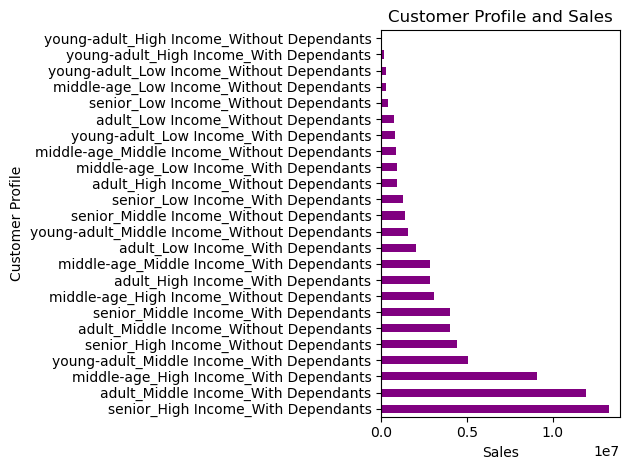

In [58]:
bar_customer_profile = customer_profile_sale_sorted.plot.barh(title = 'Customer Profile and Sales', 
                                                              xlabel = 'Sales', ylabel = 'Customer Profile', 
                                                              color = 'purple')
plt.tight_layout()

In [59]:
# Saving
bar_customer_profile.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_customer_profile.png'))

# Ordering Habits

In [60]:
# Orders interval among customers profile
customer_profile_order = small.groupby('customer_profile')['days_since_prior_order'].mean()

In [61]:
customer_profile_sorted = customer_profile_order.sort_values(ascending=True)

In [62]:
colors = plt.cm.Purples(np.linspace(0.3, 0.8, len(customer_profile_sorted)))

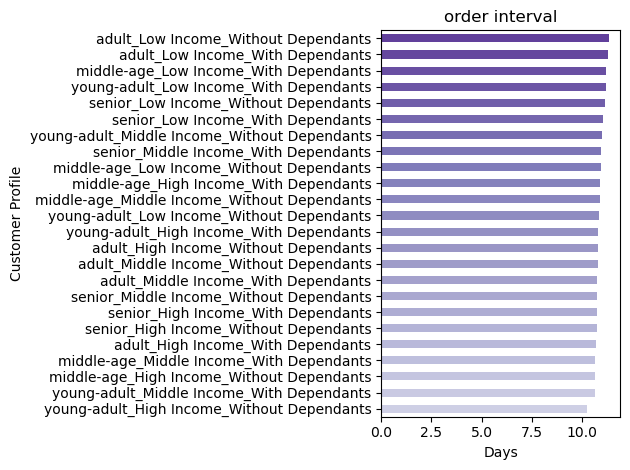

In [63]:
bar_customer_profile_orderintervals = customer_profile_sorted.plot.barh(title = 'order interval', xlabel = 'Days', ylabel = 'Customer Profile', color = colors)
plt.tight_layout()

In [64]:
# Saving
bar_customer_profile_orderintervals.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_customer_profile_orderintervals.png'))

# Different order time amoung customers 

In [65]:
# Group by 'customer_profile' and 'order_hour_of_day' to get the counts
order_hour_day = small.groupby(['customer_profile', 'order_hour_of_day']).size().unstack()

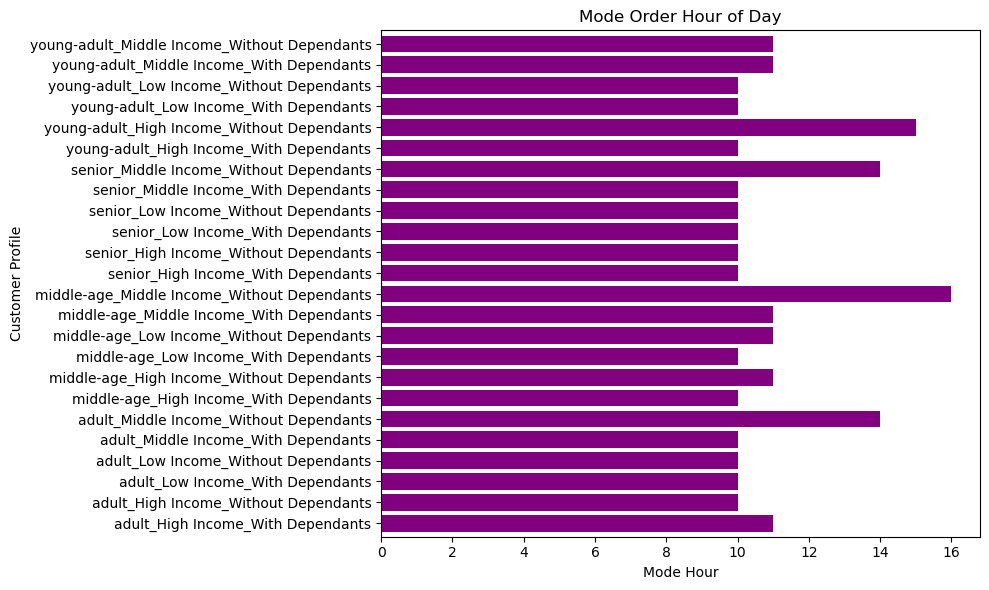

In [66]:
# Calculate the mode for each 'customer_profile'
order_hour_day_mode = small.groupby('customer_profile')['order_hour_of_day'].apply(lambda x: x.mode().iloc[0])

# Create a DataFrame for plotting
plot_data = pd.DataFrame({'customer_profile': order_hour_day_mode.index, 'mode_order_hour_of_day': order_hour_day_mode.values})

# Plotting the horizontal bar chart for mode
ax = plot_data.plot(kind='barh', x='customer_profile', y='mode_order_hour_of_day', color='purple', legend=False, title='Mode Order Hour of Day', xlabel='Mode Hour', ylabel='Customer Profile', width=0.8)

# Adjusting the size of the plot
fig = plt.gcf()
fig.set_size_inches(10, 6)  # Set the desired size

# Display the plot
plt.tight_layout()
plt.show()

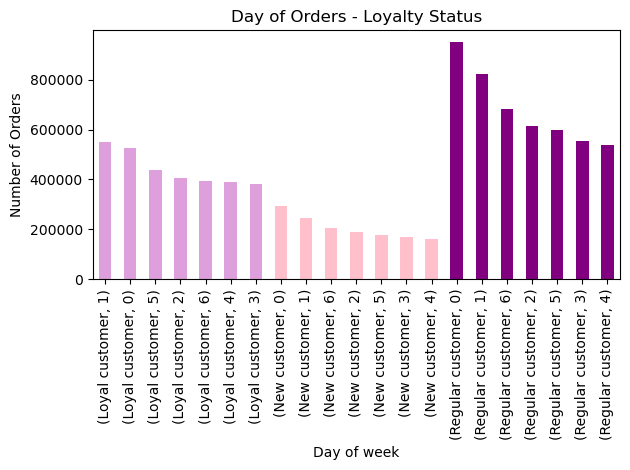

In [67]:
bar_day_loyalty = small.groupby('loyalty_flag')['orders_day_of_week'].value_counts().plot.bar(title = 'Day of Orders - Loyalty Status', xlabel = 'Day of week', ylabel = 'Number of Orders', color=['plum'] * 7 + ['pink'] * 7 + ['purple'] * 7)
plt.tight_layout()

# Save the figure as an image
bar_day_loyalty.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'bar_day_loyalty.png'))

# Departments and Orders

In [68]:
# Mapping of department IDs to department names
department_mapping = {
    1: "frozen",
    2: "other",
    3: "bakery",
    4: "produce",
    5: "alcohol",
    6: "international",
    7: "beverages",
    8: "pets",
    9: "dry goods pasta",
    10: "bulk",
    11: "personal care",
    12: "meat seafood",
    13: "pantry",
    14: "breakfast",
    15: "canned goods",
    16: "dairy eggs",
    17: "household",
    18: "babies",
    19: "snacks",
    20: "deli",
}

In [69]:
# Create the 'department_name' column
small['department_name'] = small['department_id'].map(department_mapping).fillna("missing")

/var/folders/17/9z1yp8ss3r174mlj49ql3qgr0000gn/T/ipykernel_99593/974524927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['department_name'] = small['department_id'].map(department_mapping).fillna("missing")


In [70]:
small.head()

,product_id,product_name,department_id,prices,user_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,add_to_cart_order,...,dependants,family_status,income,region,income_category,age_group,avg_dependant,depend_flag,customer_profile,department_name
0,1,Chocolate Sandwich Cookies,19,5.80,138,28,6,11,3.00,5,...,1,married,49620,Midwest,Low Income,senior,1.00,With Dependants,senior_Low Income_With Dependants,snacks
2,907,Premium Sliced Bacon,12,20.00,138,1,5,13,NaN,4,...,1,married,49620,Midwest,Low Income,senior,1.00,With Dependants,senior_Low Income_With Dependants,meat seafood
3,907,Premium Sliced Bacon,12,20.00,138,10,5,14,6.00,1,...,1,married,49620,Midwest,Low Income,senior,1.00,With Dependants,senior_Low Income_With Dependants,meat seafood
6,4913,Table Water Crackers,19,4.40,138,23,5,13,24.00,3,...,1,married,49620,Midwest,Low Income,senior,1.00,With Dependants,senior_Low Income_With Dependants,snacks
10,7987,Hazelnut Spread with Cocoa,13,12.80,138,5,0,9,14.00,3,...,1,married,49620,Midwest,Low Income,senior,1.00,With Dependants,senior_Low Income_With Dependants,pantry


In [71]:
# Create a dataframe to group the data by 'department_name' and 'loyalty_flag'
df_small_grouped = small.groupby(['department_name', 'loyalty_flag']).size().unstack()

In [72]:
df_small_grouped = df_small_grouped.sort_values(by = 'Regular customer', ascending = False)

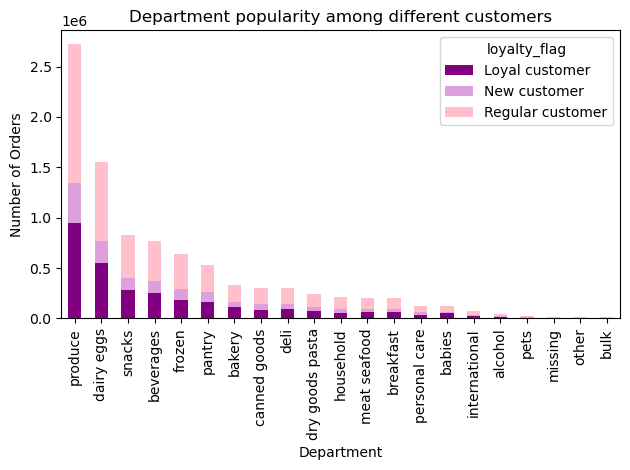

In [73]:
# Plot the data using a bar chart
colors = ['purple', 'plum','pink']
bar_dep_grouped = df_small_grouped.plot(kind = 'bar', stacked = True, color = colors)
plt.title('Department popularity among different customers')
plt.xlabel('Department')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

In [74]:
# Saving
bar_dep_grouped.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'department-Loyalty.png'))

# Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure.

In [75]:
# Group by customer_id and calculate max, mean, and min
profile_aggregated = small.groupby('user_id').agg({
    'Age': ['max', 'mean', 'min'],
    'dependants': ['max', 'mean', 'min']
}).reset_index()

In [76]:
# Rename columns for clarity
profile_aggregated.columns = ['user_id', 
                              'max_age', 'mean_age', 'min_age',
                              'max_dependants', 'mean_dependants', 'min_dependants']

In [77]:
# Display the aggregated DataFrame
print(profile_aggregated)

        user_id  max_age  mean_age  min_age  max_dependants  mean_dependants  \
0             1       31     31.00       31               3             3.00   
1             2       68     68.00       68               3             3.00   
2             3       33     33.00       33               3             3.00   
3             4       31     31.00       31               3             3.00   
4             7       39     39.00       39               2             2.00   
...         ...      ...       ...      ...             ...              ...   
162532   206203       81     81.00       81               3             3.00   
162533   206206       25     25.00       25               2             2.00   
162534   206207       76     76.00       76               1             1.00   
162535   206208       64     64.00       64               1             1.00   
162536   206209       74     74.00       74               3             3.00   

        min_dependants  
0             

#  Compare your customer profiles with regions and departments. Can you identify a link between them? Customers may demonstrate different behaviors across regions, which could make this information important.

In [78]:
# Create a dataframe to group the data by 'department_name' and 'region'
df_dep_region= small.groupby(['department_name', 'region']).size().unstack()

In [79]:
df_dep_region = df_dep_region.sort_values(by = 'South', ascending = False)

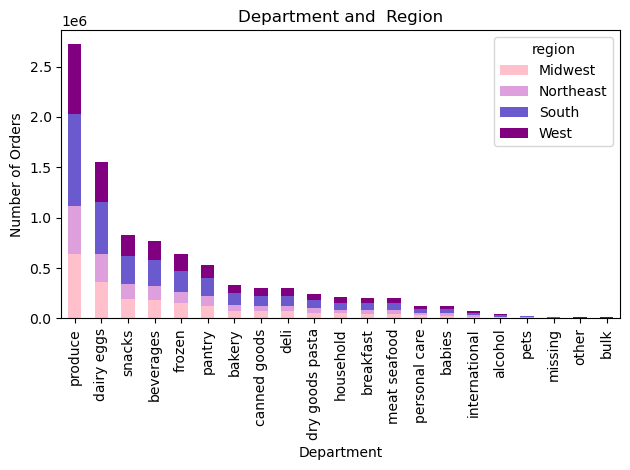

In [80]:
# Plot the data using a bar chart
colors = ['pink', 'plum', '#6A5ACD', 'purple']
bar_dep_region =df_dep_region.plot(kind = 'bar', stacked = True, color = colors)
plt.title('Department and  Region')
plt.xlabel('Department')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

In [81]:
# Saving
bar_dep_region.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'department-stacked.png'))

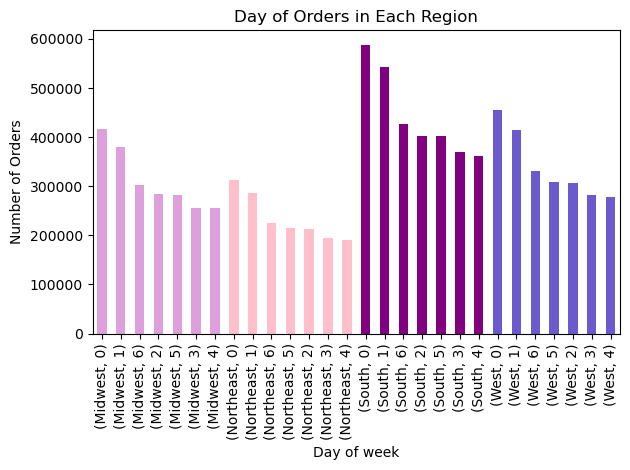

In [82]:
# difference of order behavior among regions
bar_day_region = small.groupby('region')['orders_day_of_week'].value_counts().plot.bar(title = 'Day of Orders in Each Region', xlabel = 'Day of week', ylabel = 'Number of Orders',color=['plum'] * 7 + ['pink'] * 7+['purple'] * 7 + ['#6A5ACD'] * 7)
plt.tight_layout()

# Saving
bar_day_region.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'department-stacked.png'))

# Observing products populity among customers

In [83]:
# Products Poularity
#customer profile and sales 
product_pop = small.groupby('product_name')['order_number'].sum()

In [84]:
product_pop_sort= product_pop.sort_values(ascending=False)

In [85]:
colors = plt.cm.Purples(np.linspace(0.8, 0.3, len(product_pop_sort)))

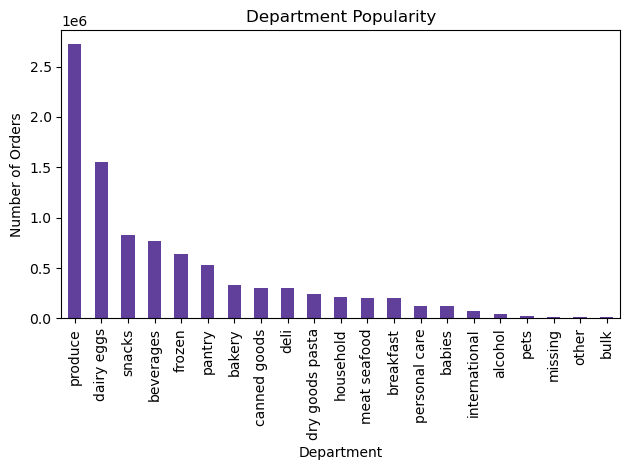

In [86]:
bar_depart_pop = small['department_name'].value_counts(dropna = False).plot.bar(title = 'Department Popularity', xlabel = 'Department', ylabel = 'Number of Orders', color = colors)
plt.tight_layout()

In [87]:
# Saving
bar_depart_pop .figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'department-popularity.png'))

# Additional visualizations

/var/folders/17/9z1yp8ss3r174mlj49ql3qgr0000gn/T/ipykernel_99593/1817094983.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['department_grouped'] = small['department_name'].where(small['department_name'].isin(top_departments))


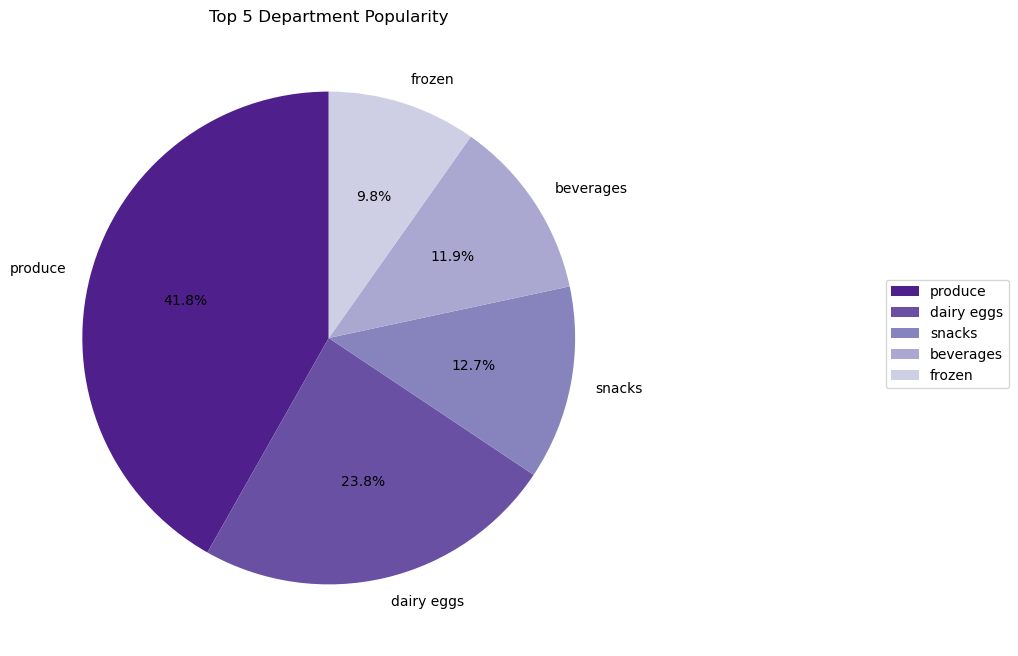

In [88]:
# Calculate the counts of each department
department_counts = small['department_name'].value_counts()

# Identify the top 10 departments
top_departments = department_counts.head(5).index

# Group other departments into "Other"
small['department_grouped'] = small['department_name'].where(small['department_name'].isin(top_departments))

# Calculate the percentage of each department group
department_percentage = small['department_grouped'].value_counts(normalize=True) * 100

# Define shades of red
shades_of_red = plt.cm.Purples(np.linspace(0.9, 0.3, len(department_percentage)))

# Create a pie chart with shades of red
fig, ax = plt.subplots(figsize=(8, 8))
pie = ax.pie(department_percentage, labels=department_percentage.index, autopct='%1.1f%%', startangle=90, colors=shades_of_red)

# Add a legend with shades of red
ax.legend(pie[0], department_percentage.index, bbox_to_anchor=(1.2, 0.5), loc="center left", fontsize=10, bbox_transform=plt.gcf().transFigure)

# Set the title
plt.title('Top 5 Department Popularity')

# Save the figure as an image
save_path = os.path.join(path, '04 Analysis', 'Visualizations', 'top_departments_pie_chart.png')
plt.savefig(save_path, bbox_inches='tight')

# Display the pie chart
plt.show()

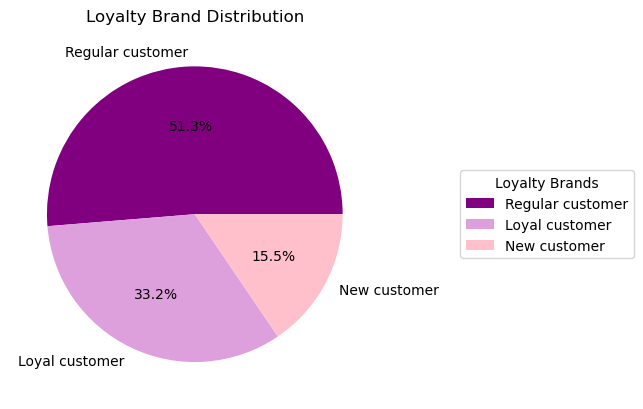

In [89]:
# Loyalty brand distribution
# Calculate the frequency distribution of 'loyalty_flag'
loyalty_distribution = small['loyalty_flag'].value_counts()

# Plot the pie chart
loyalty_pie = plt.pie(loyalty_distribution, labels=loyalty_distribution.index, autopct='%1.1f%%', colors=['purple', 'plum', 'pink'])
plt.title('Loyalty Brand Distribution')

# Creating legend
plt.legend(loyalty_distribution.index, title="Loyalty Brands", loc="center left", bbox_to_anchor=(1.2,0.5))

# Save figure
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'loyalty_distribution.png'), bbox_inches='tight')

# Display the plot
plt.show()

/Users/bazillaimran/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bazillaimran/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


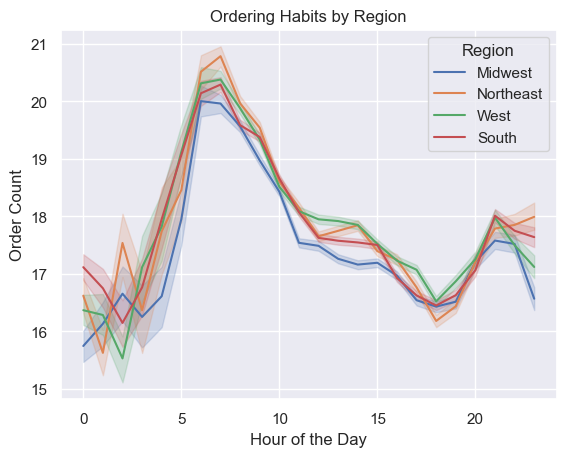

In [90]:
# Line chart using seaborn
sns.set_theme(style="darkgrid")  # Set the seaborn theme if needed
line_chart = sns.lineplot(data=small, x='order_hour_of_day', y='order_number', hue='region', )

# Set the title and labels
plt.title('Ordering Habits by Region')
plt.xlabel('Hour of the Day')
plt.ylabel('Order Count')

# Display the legend
plt.legend(title='Region', loc='upper right')

# Show the plot
plt.show()

In [91]:
#saving as png
line_chart.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_region-orde.png'))

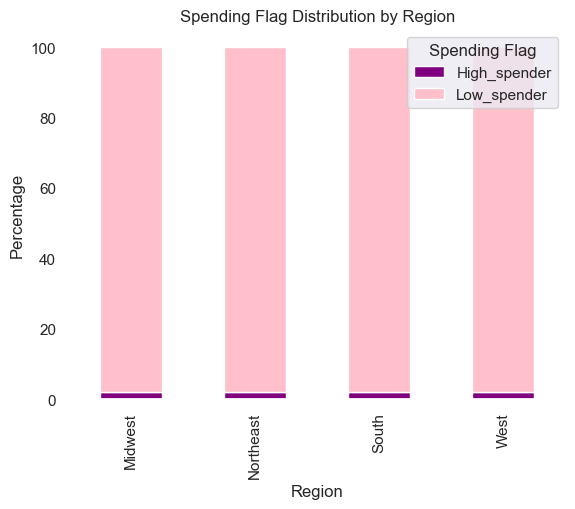

In [92]:
#making groups and normalizing the result
spending_by_region = small.groupby('region')['spender_flag'].value_counts(normalize=True).unstack() * 100
#defining colors
colors = ['purple', 'pink']

# Plotting the bar chart
ax = spending_by_region.plot(kind='bar', stacked=True, color=colors)
fig = plt.gcf()
ax.set_facecolor('white')

# Adding labels and title
ax.set_xlabel('Region')
ax.set_ylabel('Percentage')
ax.set_title('Spending Flag Distribution by Region')

# Display the legend
ax.legend(title='Spending Flag', loc='upper right')
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'spending region.png'), bbox_inches='tight', pad_inches=0.1)

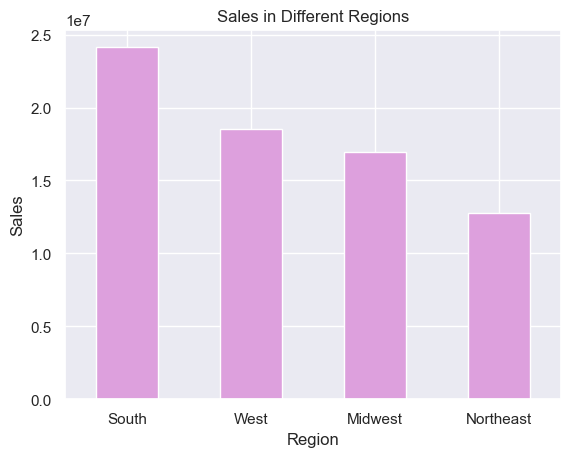

In [93]:
#purchased product prices in different regions
bar_price_region = small.groupby('region')['prices'].sum().sort_values(ascending=False).plot.bar(
    title='Sales in Different Regions', xlabel='Region', ylabel='Sales', color='plum'
)
plt.xticks(rotation=0)
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'sales_region_bar.png'), bbox_inches='tight', pad_inches=0.1)
plt.show()

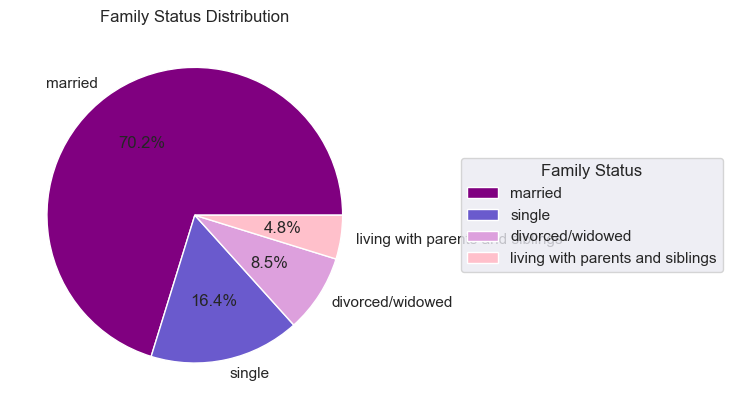

In [94]:
# df_s['fam_status'] is a categorical variable
family_status_counts = small['family_status'].value_counts()

# Plotting pie chart with percentages
pie_fam_status = plt.pie(family_status_counts, labels=family_status_counts.index, autopct='%1.1f%%', colors=['purple', '#6A5ACD', 'plum', 'pink'])

# Adding title
plt.title('Family Status Distribution')

# Creating legend
plt.legend(family_status_counts.index, title="Family Status", loc="center left", bbox_to_anchor=(1.2,0.5))

# Save the figure as an image
save_path = os.path.join(path, '04 Analysis', 'Visualizations', 'family.png')
plt.savefig(save_path, bbox_inches='tight')

# Display the plot
plt.show()

In [95]:
# Making orders-family status -age group chart
# Create a dataframe to group the data by 'fam_status' and 'age_flag'
df_s_g = small.groupby(['family_status', 'age_group']).size().unstack()

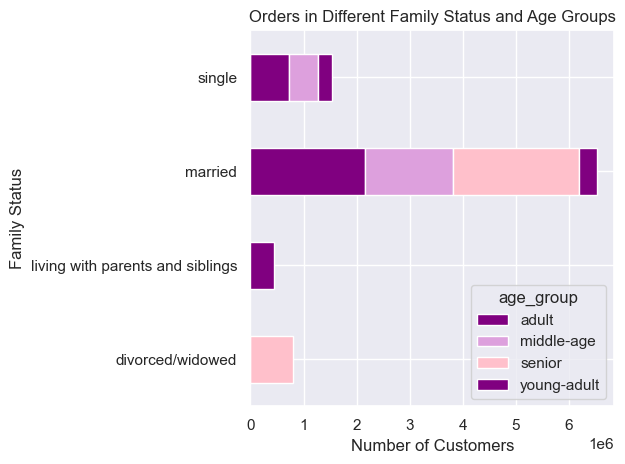

In [96]:
# Plot the data using a bar chart
colors = ['purple', 'plum','pink']
bar__age = df_s_g.plot(kind = 'barh', stacked = True, color = colors)
plt.title('Orders in Different Family Status and Age Groups')
plt.xlabel('Number of Customers')
plt.ylabel('Family Status')
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'fam_age.png'), bbox_inches='tight', pad_inches=0.1)
plt.show()